In [1]:
import sweetviz as sv
import pandas as pd
import numpy as np
import os
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append( '../helper/' )
import createbase
import preprocess

DATA_DIR = '../assessment_data/'
ARTIFACTS_DIR = '../artifacts/'

In [2]:
# Create the base of policies
df_base = createbase.create_base()

In [3]:
df_base_1 = df_base.copy()

df_base_1.drop(['AGT_CHANNEL', 'AGT_STATUS', 'B', 'C', 'D', 'E', 'PROD_SUBCAT_IND_1', 'PROD_SUBCAT_IND_2'], axis=1, inplace=True)

In [4]:
df_base_1.head()

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PRODUCT_CD,ANP_RIDER,VIT_MBR_IND,MAIN_NEED
0,1,3640,LAT,010102,R,P001664420,2020-03-26,Cat 2,ACC0,0.0,0,Critical Illness
1,1,3640,LAT,010103,R,P001664420,2020-03-26,Cat 2,AHI0,0.0,0,Income
2,1,3640,LAT,010108,R,P001664420,2020-03-26,Cat 3,VIT1,0.0,0,Life
3,1,3640,LAT,010200,R,P001664420,2020-03-26,Cat 3,ART0,120.0,0,Savers
4,1,3640,LAT,010107,R,P001664420,2020-03-26,Cat 3,ART2,0.0,0,Accident


In [ ]:
# Run Sweetviz EDA
sv_report = sv.analyze(df_base_1)
sv_report.show_html(os.path.join(ARTIFACTS_DIR, 'sv_report_df_base.html'))

## EDA

Must all basic policies have > 0 ANP?

Findings: There are 143 basic policies with 0 ANP. This may be valid or invalid, need further clarification.

In [5]:
# Must all basic policies have > 0 premium?
df_1 = df_base_1[df_base_1['COVERAGE_TYPE_IND'] == 'B']

df_1 = (df_1.groupby(['POLICY_NO'])
    .agg(
        TOTAL_ANP=('ANP_RIDER', 'sum')
        )
    )

res_1 = len(df_1[df_1['TOTAL_ANP'] == 0])

print(f'There are {res_1} basic policies with 0 ANP')

There are 143 basic policies with 0 ANP


Do all future dated policies have 0 ANP?

Findings: Some, with the assumption that policy purchase date after 2021-03-01 are considered 'future'

In [6]:
# Do all future dated policies have 0 ANP?
df_1 = df_base_1[df_base_1['PURCHASE_DT'] >= '2021-03-01']

print(len(df_1[df_1['ANP_RIDER'] == 0]))
print(len(df_1[df_1['ANP_RIDER'] != 0]))

77
61


Can 1 policy be handled by multiple agents?

Findings: No, 1 policy tied to 1 agent only

In [7]:
# Can 1 policy be handled by multiple agents?
df_1 = (df_base_1.groupby(['POLICY_NO'])
    .agg(
        N_AGENTS=('AGT_CD', 'nunique'),
        )
    )

df_1[df_1['N_AGENTS'] > 1]

,N_AGENTS
POLICY_NO,


Can 1 policy have multiple S_BASE tagging?

Findings: No, 1 policy tied to 1 S_BASE

In [8]:
# Can 1 policy have multiple S_BASE tagging?
df_1 = (df_base_1.groupby(['POLICY_NO'])
    .agg(
        N_SBASE=('S_BASE', 'nunique'),
        )
    )

df_1[df_1['N_SBASE'] > 1]

,N_SBASE
POLICY_NO,


Next, we see a spike of policies sold alongside total ANP increase from May 2020. The surge in demand for insurance comes after Malaysia's first MCO order being lifted during the COVID pandemic.

In [9]:
# Sales trend of Product Category by purchase date
df_base_2 = df_base_1[df_base_1['PURCHASE_DT'] < '2022-07-01']
df_base_2['PURCHASE_DT_1'] = df_base_2['PURCHASE_DT'].dt.strftime('%Y%m')

df_base_3 = (df_base_2.groupby(['PROD_CAT', 'PURCHASE_DT_1'])
                .agg(
                    N_POLICIES=('POLICY_NO', 'nunique'),
                    TOTAL_ANP=('ANP_RIDER', 'sum')
                    )
                .reset_index()
             )

fig = px.line(df_base_3, x="PURCHASE_DT_1", y="N_POLICIES", color="PROD_CAT")
fig.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_19552\1224746780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_2['PURCHASE_DT_1'] = df_base_2['PURCHASE_DT'].dt.strftime('%Y%m')


In [10]:
fig = px.line(df_base_3, x="PURCHASE_DT_1", y="TOTAL_ANP", color="PROD_CAT")
fig.show()

The top main needs are Life, Disability, Medical and Savers

In [11]:
# Sales trend of Main Need by purchase date
df_base_2['MAIN_NEED'].fillna('N/A', inplace=True)
df_base_4 = (df_base_2.groupby(['MAIN_NEED', 'PURCHASE_DT_1'])
                .agg(
                    N_POLICIES=('POLICY_NO', 'nunique'),
                    TOTAL_ANP=('ANP_RIDER', 'sum')
                    )
                .reset_index()
             )

fig = px.line(df_base_4, x="PURCHASE_DT_1", y="N_POLICIES", color="MAIN_NEED")
fig.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_19552\3415159312.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
fig = px.line(df_base_4, x="PURCHASE_DT_1", y="TOTAL_ANP", color="MAIN_NEED")
fig.show()

## Questions

In [13]:
# No. of Policies and Total ANP by Product Category
(df_base_1.groupby(['PROD_CAT'])
    .agg(
        N_POLICIES=('POLICY_NO', 'nunique'),
        TOTAL_ANP=('ANP_RIDER', 'sum')
        )
    )

,N_POLICIES,TOTAL_ANP
PROD_CAT,,
Cat 1,11765,10232935.0
Cat 2,59499,5300201.5
Cat 3,101787,25273960.0


In [14]:
# No. of agents who sold at least 5 Vitality attached policies
df_vit = df_base_1[df_base_1['VIT_MBR_IND'] == 1]

df_vit_1 = (df_vit.groupby(['AGT_CD'])
        .agg(
            N_VIT_POLICIES=('POLICY_NO', 'nunique'),
            )
        .reset_index()
)

df_vit_2 = df_vit_1[df_vit_1['N_VIT_POLICIES'] >= 5]

num = len(df_vit_2['AGT_CD'])
dem = df_base_1['AGT_CD'].nunique()

print(f'No. of agents: {num} ({num/dem:.1%})')

No. of agents: 1070 (33.1%)


In [15]:
# No. of policies with at least 3 Riders attached
df_pol_1 = (df_base_1.groupby(['POLICY_NO'])
                .apply(lambda x: x[x['COVERAGE_TYPE_IND'] == 'R']['COVERAGE_TYPE_IND'].count())
                .reset_index(name='N_RIDERS')
            )

df_pol_2 = df_pol_1[df_pol_1['N_RIDERS'] >= 3]

num = len(df_pol_2['POLICY_NO'])
dem = df_base_1['POLICY_NO'].nunique()

print(f'No. of policies: {num} ({num/dem:.1%})')

No. of policies: 59046 (47.2%)


## EDA on Agent level data

In [5]:
df_agt_f = preprocess.preprocess_agent_level(df_base_1)

print(df_agt_f.shape)

(3231, 60)


In [6]:
df_agt_f.head()

,AGT_CD,N_POLICIES_LA,N_POLICIES_LAT,N_POLICIES_POLA,TOTAL_ANP_LA,TOTAL_ANP_LAT,TOTAL_ANP_POLA,TOTAL_POLICIES,TOTAL_ANP,TICKET_SIZE,...,TOTAL_ANP_Disability,TOTAL_ANP_Endowment,TOTAL_ANP_Income,TOTAL_ANP_Life,TOTAL_ANP_Medical,TOTAL_ANP_N/A,TOTAL_ANP_Other Medical,TOTAL_ANP_Payor/Waiver,TOTAL_ANP_Savers,COUNT_MAINNEED_TYPE
0,1,286.0,NaN,NaN,21206.500000,NaN,NaN,286.0,21206.500000,74.148601,...,56.82,1179.030029,NaN,16948.480469,309.899994,NaN,0.0,140.559998,818.489990,8
1,10,850.0,44.0,22.0,72481.078125,3377.250000,1235.77002,916.0,77094.098145,84.163863,...,0.00,4407.870117,30.0,31464.000000,10808.160156,NaN,0.0,303.619995,28844.679688,10
2,1000,367.0,19.0,NaN,62478.058594,7710.850098,NaN,386.0,70188.908691,181.836551,...,0.00,14967.559570,0.0,32893.421875,332.779999,NaN,0.0,328.989990,18804.789062,9
3,1001,235.0,NaN,NaN,18381.490234,NaN,NaN,235.0,18381.490234,78.219107,...,0.00,1239.030029,0.0,11181.400391,3769.550049,NaN,0.0,98.089996,1509.020020,9
4,1002,NaN,429.0,NaN,NaN,32215.369141,NaN,429.0,32215.369141,75.094101,...,0.00,3438.030029,NaN,17138.800781,2315.360107,3168.800049,NaN,1249.300049,2440.639893,8


In [7]:
df_agt_f.columns

Index(['AGT_CD', 'N_POLICIES_LA', 'N_POLICIES_LAT', 'N_POLICIES_POLA',
       'TOTAL_ANP_LA', 'TOTAL_ANP_LAT', 'TOTAL_ANP_POLA', 'TOTAL_POLICIES',
       'TOTAL_ANP', 'TICKET_SIZE', 'COUNT_RATIO_LA', 'COUNT_RATIO_LAT',
       'COUNT_RATIO_POLA', 'ANP_RATIO_LA', 'ANP_RATIO_LAT', 'ANP_RATIO_POLA',
       'COUNT_SBASE_TYPE', 'N_LINE_ITEM_B', 'N_LINE_ITEM_R', 'TOTAL_ANP_B',
       'TOTAL_ANP_R', 'R_B_COUNT_RATIO', 'R_B_ANP_RATIO', 'N_LINE_ITEM_Cat 1',
       'N_LINE_ITEM_Cat 2', 'N_LINE_ITEM_Cat 3', 'TOTAL_ANP_Cat 1',
       'TOTAL_ANP_Cat 2', 'TOTAL_ANP_Cat 3', 'COUNT_RATIO_CAT1',
       'COUNT_RATIO_CAT2', 'COUNT_RATIO_CAT3', 'ANP_RATIO_CAT1',
       'ANP_RATIO_CAT2', 'ANP_RATIO_CAT3', 'COUNT_PRODCAT_TYPE',
       'N_VIT_POLICIES', 'N_LINE_ITEM_Accident',
       'N_LINE_ITEM_Critical Illness', 'N_LINE_ITEM_Disability',
       'N_LINE_ITEM_Endowment', 'N_LINE_ITEM_Income', 'N_LINE_ITEM_Life',
       'N_LINE_ITEM_Medical', 'N_LINE_ITEM_N/A', 'N_LINE_ITEM_Other Medical',
       'N_LINE_ITEM

In [ ]:
# Run Sweetviz EDA
sv_report = sv.analyze(df_agt_f)
sv_report.show_html(os.path.join(ARTIFACTS_DIR, 'sv_report_df_agt_f.html'))

c:\Users\benja\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


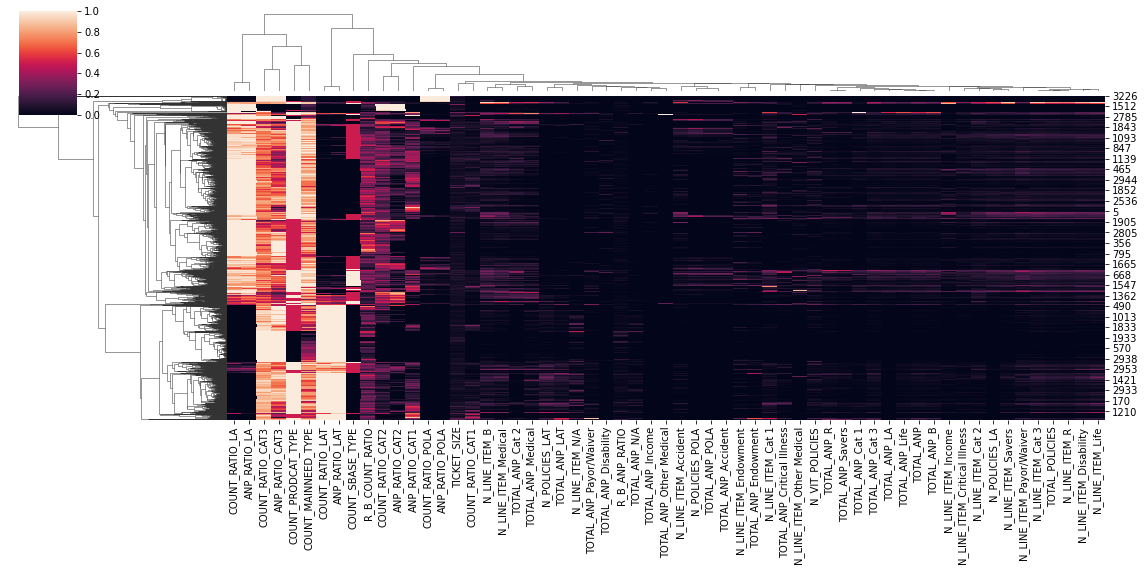

In [8]:
df_agt_f1 = df_agt_f.copy()
df_agt_f1.fillna(0, inplace=True)
df_agt_f1.drop('AGT_CD', axis=1, inplace=True)
# df_agt_f1 = df_agt_f1[[
#        'COUNT_RATIO_LA', 'COUNT_RATIO_LAT', 'COUNT_RATIO_POLA',
#        'ANP_RATIO_LA', 'ANP_RATIO_LAT', 'ANP_RATIO_POLA', 'R_B_COUNT_RATIO', 'COUNT_RATIO_CAT1', 'COUNT_RATIO_CAT2',
#        'COUNT_RATIO_CAT3', 'ANP_RATIO_CAT1', 'ANP_RATIO_CAT2',
#        'ANP_RATIO_CAT3', 'TOTAL_ANP_LA', 'TOTAL_ANP_LAT', 'TOTAL_ANP_Cat 3']]

sns.clustermap(df_agt_f1,
               figsize=(16, 8),
               standard_scale=1,
              #  z_score=1,
)